In [1]:
!git clone https://github.com/Sidd1609/CBIVR

fatal: destination path 'CBIVR' already exists and is not an empty directory.


In [2]:
!ls CBIVR

IMG             driving_log.csv


In [3]:
import sys
!{sys.executable} -m pip install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [5]:
datadir = 'CBIVR/'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

<ipython-input-5-0eacd2428cdf>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/center_2021_05_12_02_53_00_210.jpg   
1  /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/center_2021_05_12_02_53_00_313.jpg   
2  /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/center_2021_05_12_02_53_00_419.jpg   
3  /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/center_2021_05_12_02_53_00_521.jpg   
4  /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/center_2021_05_12_02_53_00_629.jpg   

                                                                                                                      left  \
0   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/left_2021_05_12_02_53_00_210.jpg   
1   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/left_2021_05_12_02_53_00_313.jpg   
2   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/left_2021_05_12_02_53_00_419.jpg   
3   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/left_2021_05_12_02_53_00_521.jpg   
4   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/left_2021_05_12_02_53_00_629.jpg   

                                                                                                                      right  \
0   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/right_2021_05_12_02_53_00_210.jpg   
1   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/right_2021_05_12_02_53_00_313.jpg   
2   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/right_2021_05_12_02_53_00_419.jpg   
3   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/right_2021_05_12_02_53_00_521.jpg   
4   /Users/srisiddarthchakaravarthy/Desktop/COL/SEM6/CBIVR/PROJ/materials /Data/Train/IMG/right_2021_05_12_02_53_00_629.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000079  
1  0.0       0.0       0.0      0.000078  
2  0.0       0.0       0.0      0.000080  
3  0.0       0.0       0.0      0.000078  
4  0.0       0.0       0.0      0.000078

In [6]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2021_05_12_02_53_00_210.jpg  left_2021_05_12_02_53_00_210.jpg   
1  center_2021_05_12_02_53_00_313.jpg  left_2021_05_12_02_53_00_313.jpg   
2  center_2021_05_12_02_53_00_419.jpg  left_2021_05_12_02_53_00_419.jpg   
3  center_2021_05_12_02_53_00_521.jpg  left_2021_05_12_02_53_00_521.jpg   
4  center_2021_05_12_02_53_00_629.jpg  left_2021_05_12_02_53_00_629.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_05_12_02_53_00_210.jpg  0.0       0.0       0.0      0.000079  
1  right_2021_05_12_02_53_00_313.jpg  0.0       0.0       0.0      0.000078  
2  right_2021_05_12_02_53_00_419.jpg  0.0       0.0       0.0      0.000080  
3  right_2021_05_12_02_53_00_521.jpg  0.0       0.0       0.0      0.000078  
4  right_2021_05_12_02_53_00_629.jpg  0.0       0.0       0.0      0.000078

<b>The bar graph is fairly balanced as we have plots on both sides of the mode, also a huge part of the plot is biased at the zero angle and if the model were trained on this data then we would end up having our self driving vehicle driving in a straight path for most of the time, due to biased training data</b>

[-0.9117597  -0.83528931 -0.75881892 -0.68234854 -0.60587815 -0.52940776
 -0.45293737 -0.37646698 -0.2999966  -0.22352621 -0.14705582 -0.07058543
  0.00588496  0.08235534  0.15882573  0.23529612  0.31176651  0.3882369
  0.46470728  0.54117767  0.61764806  0.69411845  0.77058884  0.84705922
  0.92352961  1.        ]


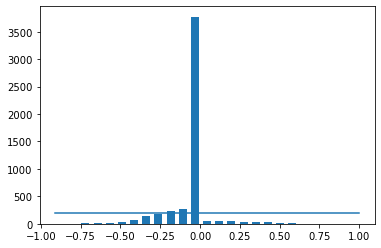

In [7]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 5017
removed: 3679
remaining: 1338


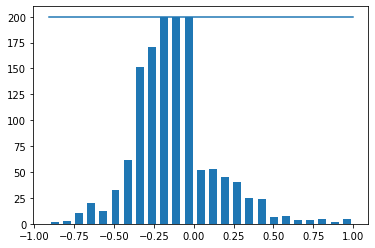

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

# Training and Validation split</b>

center      center_2021_05_12_02_53_01_603.jpg
left        left_2021_05_12_02_53_01_603.jpg  
right       right_2021_05_12_02_53_01_603.jpg 
steering   -0.209337                          
throttle    1                                 
reverse     0                                 
speed       2.61414                           
Name: 13, dtype: object
Training Samples: 3211
Valid Samples: 803


Text(0.5, 1.0, 'Validation set')

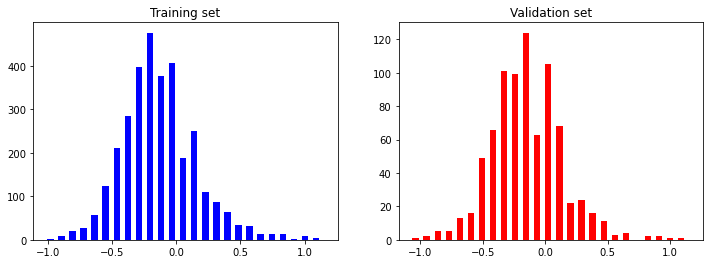

In [9]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

<b>Here we try to zoom the images to view specific features and extract them

# Preprocessing images
<b>zooming into the image

In [10]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

# Augmentation of images

Text(0.5, 1.0, 'Zoomed Image')

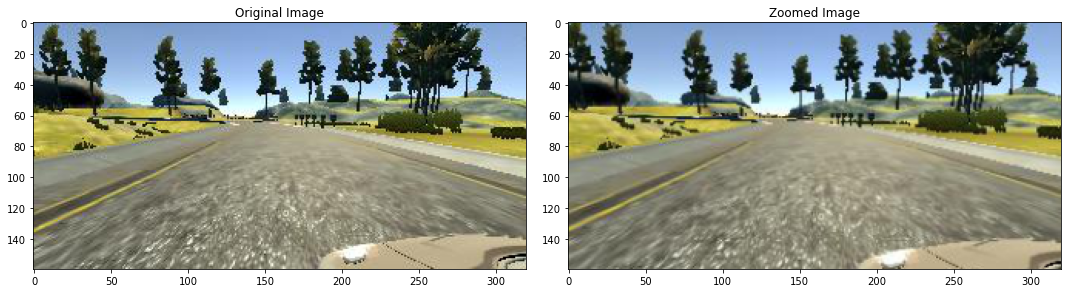

In [11]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

# Panning into the image¶

Text(0.5, 1.0, 'Panned Image')

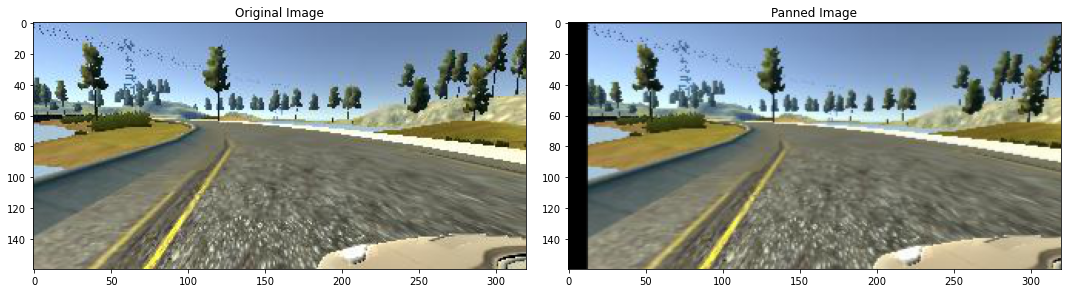

In [12]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

# Altering the Brightness of the image

Text(0.5, 1.0, 'Brightness altered image ')

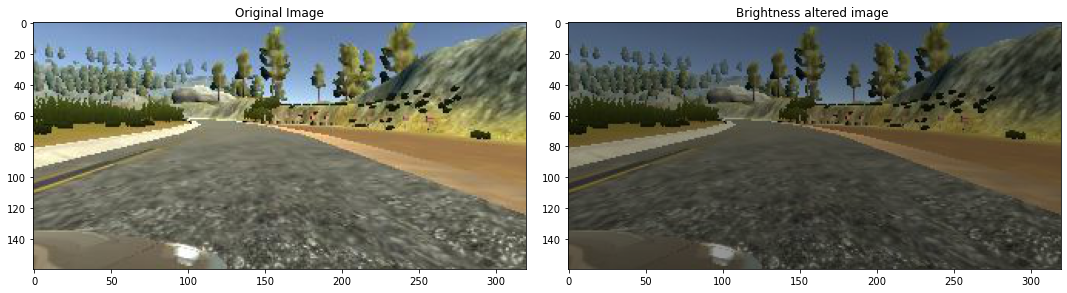

In [13]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

# Image random Flipping:
<b>Image flipping is used to randomly flip generated images so that we balance our datasets. This is similar to the training and validation split bar graphs plotted above which was done to balance steering angle between the positive and well as negative sides

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.20482471')

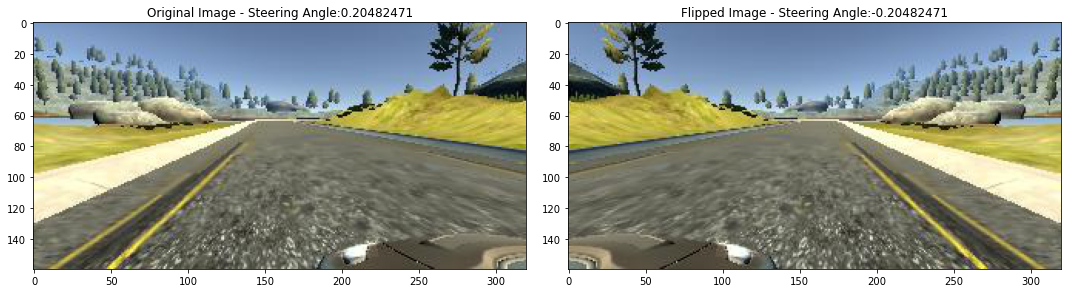

In [14]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

# Random augmentation of images
<b>The code causes the running of above stated random augmentations for 50% of the time

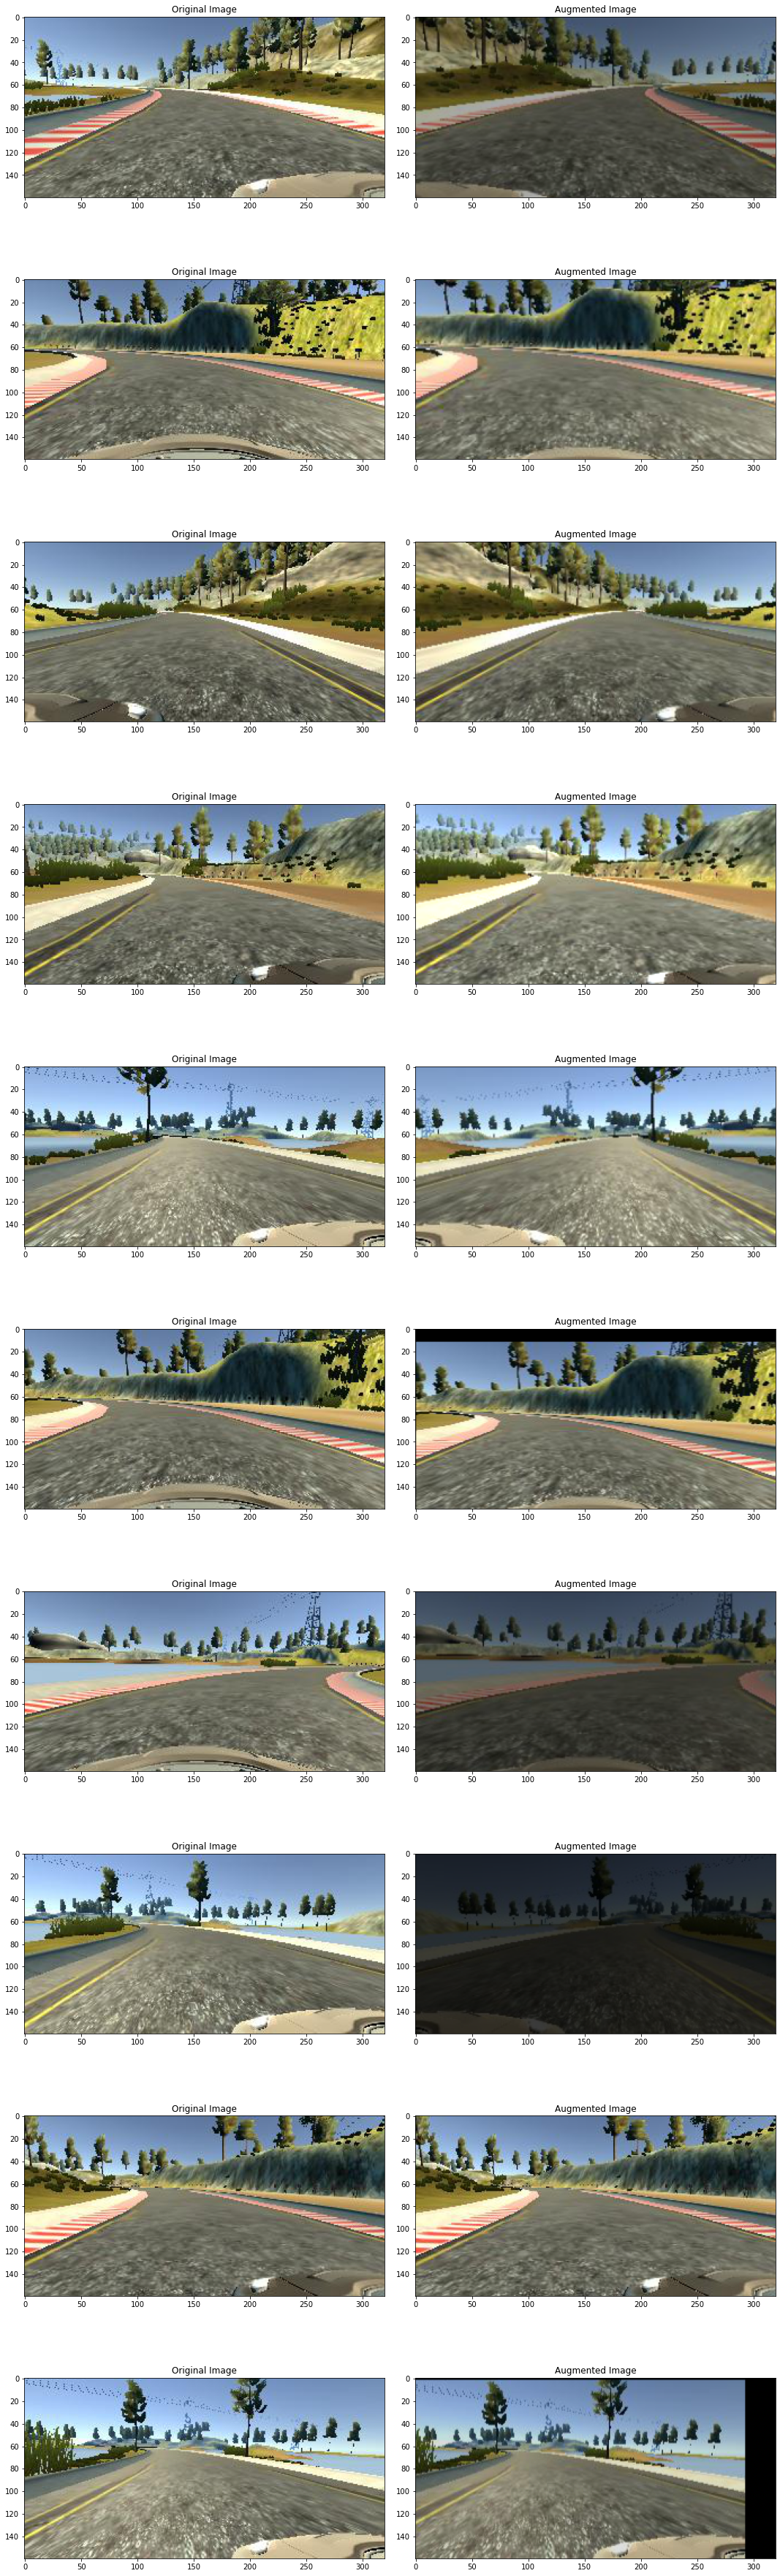

In [15]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

<b>First we extract useful patches of the images by removing the unwanted region. Using RGB2YUV and Gaussian Blur we remove noise in the image and filter the image followed by image normalization.

Text(0.5, 1.0, 'Preprocessed Image')

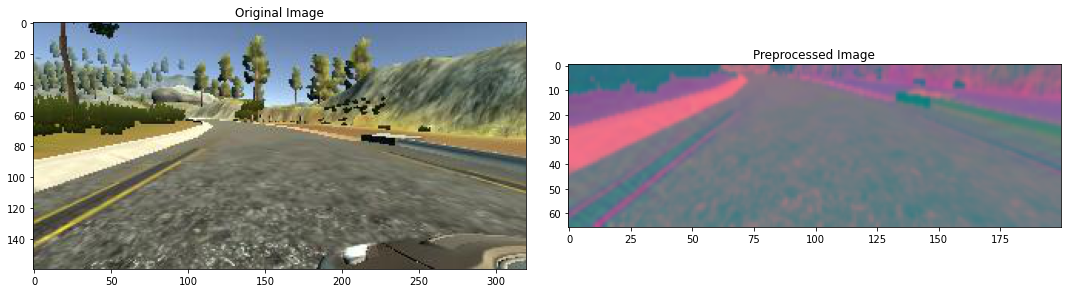

In [16]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [17]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
        random_index = random.randint(0, len(image_paths) - 1)
      
        if istraining:
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
        else:
            im = mpimg.imread(image_paths[random_index])
            steering = steering_ang[random_index]
      
        im = img_preprocess(im)
        batch_img.append(im)
        batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

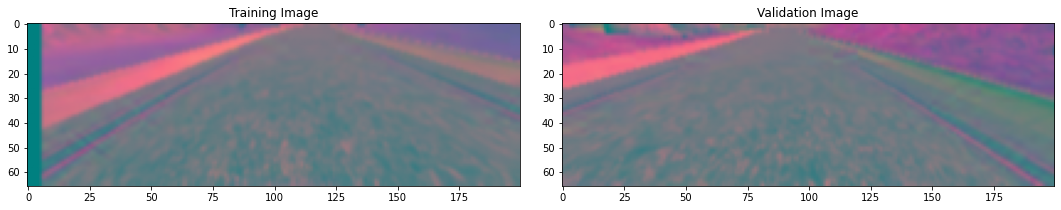

In [18]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [19]:
def nvidia_model():
    model = Sequential()
 
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
 
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
 
 
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
 
 
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation ='relu'))
    model.add(Dense(1))
 
 
    optimizer= Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
 
    return model

In [20]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [21]:
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

/Users/srisiddarthchakaravarthy/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 211s 702ms/step - loss: 0.0805 - val_loss: 0.0346
Epoch 2/10
300/300 [==============================] - 285s 951ms/step - loss: 0.0513 - val_loss: 0.0372
Epoch 3/10
300/300 [==============================] - 373s 1s/step - loss: 0.0486 - val_loss: 0.0322
Epoch 4/10
300/300 [==============================] - 330s 1s/step - loss: 0.0465 - val_loss: 0.0326
Epoch 5/10
300/300 [==============================] - 291s 971ms/step - loss: 0.0417 - val_loss: 0.0305
Epoch 6/10
300/300 [==============================] - 259s 865ms/step - loss: 0.0408 - val_loss: 0.0298
Epoch 7/10
300/300 [==============================] - 250s 834ms/step - loss: 0.0395 - val_loss: 0.0281
Epoch 8/10
300/300 [==============================] - 248s 827ms/step - loss: 0.0392 - val_loss: 0.0282
Epoch 9/10
300/300 [==============================] - 263s 880ms/step - loss: 0.0391 - val_loss: 0.0290
Epoch 10/10
300/300 [==============================] - 275s 921ms/step

Text(0.5, 0, 'Epoch')

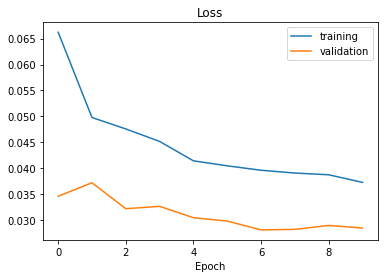

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [23]:
model.save('model.h5')